In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [2]:
!pip install -q transformers

     |████████████████████████████████| 2.6 MB 36.2 MB/s 
     |████████████████████████████████| 3.3 MB 51.4 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 
     |████████████████████████████████| 636 kB 47.6 MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/in_domain_train.tsv", delimiter="\t", header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape

(8551, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
3869,ks08,0,*,john put his gold .
423,bc01,1,NaN,someone stole my car .
7306,sks13,1,NaN,it was in the barn or it took place in the barn .
3472,ks08,1,NaN,little evidence was provided .
3709,ks08,0,*,i know the truth and that you are innocent .
6668,m_02,1,NaN,the terrier attacked the burglar and savaged t...
3488,ks08,1,NaN,the president was hoping for a good cake .
2272,l-93,0,*,june covered the blanket over the baby .
6030,c_13,0,*,the cake was have eaten .
3895,ks08,0,*,john placed behind the counter .


In [7]:
# Creating sentence, label lists and adding Bert tokens
sentences = df.sentence.values

# Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [9]:
# Find max length of sentence in the data set
max_len = float("-inf")
for x in tokenized_texts:
    if len(x) > max_len:
        max_len = len(x)

max_len

47

In [10]:
# Set the maximum sequence length.
MAX_LEN = 128

In [11]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Padding the input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [12]:
# Creating attention masks, 1's for each token followed by 0's for padding
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [13]:
# Splitting data into train and validation sets
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2021, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2021, test_size=0.1)

In [14]:
# Converting all the data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [15]:
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [16]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
model = BertModel(configuration)
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [17]:
# Loading the Hugging Face Bert Uncased Base Model 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

In [19]:
optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

epochs = 5

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
    # Training
  
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

  
    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
        # Move logits and labels to CPU
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids) 
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.5117827130798482


Epoch:  20%|██        | 1/5 [02:52<11:30, 172.69s/it]

Validation Accuracy: 0.8206018518518519
Train loss: 0.3063705939165784


Epoch:  40%|████      | 2/5 [05:45<08:38, 172.85s/it]

Validation Accuracy: 0.8256172839506173
Train loss: 0.16962303686500585


Epoch:  60%|██████    | 3/5 [08:39<05:46, 173.01s/it]

Validation Accuracy: 0.8364197530864197
Train loss: 0.10314993285554697


Epoch:  80%|████████  | 4/5 [11:32<02:52, 172.99s/it]

Validation Accuracy: 0.8341049382716049
Train loss: 0.07006167978651172


Epoch: 100%|██████████| 5/5 [14:25<00:00, 173.06s/it]

Validation Accuracy: 0.8329475308641975


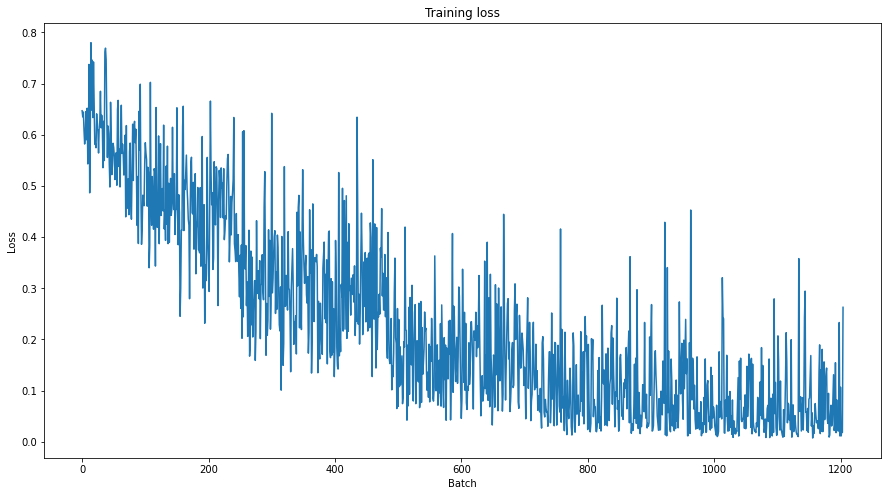

In [22]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [23]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [24]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [25]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [26]:
# scores of individual batches
matthews_set

[0.049286405809014416,
 -0.050964719143762556,
 0.5510387687779837,
 0.589872830909857,
 0.44440090347500916,
 0.7410010097502685,
 0.5204358386562267,
 0.47519096331149147,
 0.9229582069908973,
 0.7704873741021288,
 0.9229582069908973,
 0.5673665146135802,
 0.936441710371274,
 0.647150228929434,
 0.3268228676411533,
 0.4458874458874459,
 0.0]

In [27]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5711089527015469